In [1]:
!pip install tensorflow_datasets

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

#used to fix bug in keras preprocessing scope
temp = tf.zeros([4, 32, 32, 3])  # Or tf.zeros
preprocess_input(temp)
print("processed")


processed


In [3]:
IMAGE_SIZE = (224, 224)
TRAIN_SIZE = 50000
VALIDATION_SIZE = 10000
BATCH_SIZE_PER_GPU = 16
global_batch_size = (BATCH_SIZE_PER_GPU * 1)
NUM_CLASSES = 10

Dataset code

In [4]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=IMAGE_SIZE)
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(())

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

def normalize(input_image):
  return preprocess_input(input_image)

@tf.function
def load_image_train(datapoint):
  input_image, label = tf.image.resize(datapoint["image"], IMAGE_SIZE), datapoint['label']
  # if tf.random.uniform(()) > 0.5:
  #   input_image = tf.image.flip_left_right(input_image)
  augmentations = [flip, color, zoom, rotate]
  for f in augmentations:
    input_image = tf.cond(tf.random.uniform(()) > 0.75, lambda: f(input_image), lambda: input_image)

  #input_image = preprocess_input(input_image)
  input_image = normalize(input_image)

  return input_image, tf.one_hot(label, depth=NUM_CLASSES)

@tf.function
def load_image_test(datapoint):
  input_image, label = tf.image.resize(datapoint["image"], IMAGE_SIZE), datapoint['label']
  #input_image = preprocess_input(input_image)

  input_image = normalize(input_image)

  return input_image, tf.one_hot(label, depth=NUM_CLASSES)

In [5]:
dataset, info = tfds.load('cifar10', with_info=True)

In [6]:
for example in dataset['train'].take(1):
  print(example["label"])

tf.Tensor(3, shape=(), dtype=int64)


In [7]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

make the upscaled cifar dataset

In [8]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train.shuffle(buffer_size=1000).batch(global_batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


test_dataset = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(global_batch_size).repeat()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [9]:
model = tf.keras.models.load_model('./../base_model_cifar10_vgg16.h5')

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
model.compile(optimizer=tf.optimizers.SGD(learning_rate=.01, momentum=.9, nesterov=True), loss='mse', metrics=['acc'])

build training output

In [12]:
import math
class LayerBatch(tf.keras.utils.Sequence):
    
    def __init__(self, input_model, dataset):
        self.input_model = input_model
        self.dataset = dataset.__iter__()
        
    def __len__(self):
        return math.ceil(TRAIN_SIZE // global_batch_size )
    
    def __getitem__(self, index):
        X, y = self.input_model(next(self.dataset))
        return X, y
    
class LayerBatchSynth(tf.keras.utils.Sequence):
    
    def __init__(self, input_model, dataset):
        self.input_model = input_model
        self.dataset = dataset.__iter__()
        
    def __len__(self):
        return math.ceil(4224 // global_batch_size )
    
    def __getitem__(self, index):
        X, y = self.input_model(next(self.dataset))
        return X, y
    
import math
class LayerTest(tf.keras.utils.Sequence):
    
    def __init__(self, input_model, dataset):
        self.input_model = input_model
        self.dataset = dataset.__iter__()
        
    def __len__(self):
        return math.ceil(VALIDATION_SIZE // global_batch_size )
    
    def __getitem__(self, index):
        X, y = self.input_model(next(self.dataset))
        return X, y

In [13]:
def add_layers(inputs, filters, layers=2):
    print(inputs.get_shape())
    X = tf.keras.layers.SeparableConv2D(name=f'sep_conv_{build_replacement.counter}', filters=filters, 
                                        kernel_size= (3,3),
                                        padding='Same')(inputs)
    X = tf.keras.layers.BatchNormalization(name=f'batch_norm_{build_replacement.counter}')(X)
    X = tf.keras.layers.ReLU(name=f'relu_{build_replacement.counter}')(X)
    
    build_replacement.counter += 1
    
    for i in range(1, layers):
        X = tf.keras.layers.SeparableConv2D(name=f'sep_conv_{build_replacement.counter}', filters=filters,
                                            kernel_size=(3,3), 
                                            padding='Same')(X)
        X = tf.keras.layers.BatchNormalization(name=f'batch_norm_{build_replacement.counter}')(X)
        X = tf.keras.layers.ReLU(name=f'relu_{build_replacement.counter}')(X)
        build_replacement.counter += 1
    
    return X
    
def build_replacement(get_output, layers=2):
    inputs = tf.keras.Input(shape=get_output.output[0].shape[1::])
    
    X = add_layers(inputs, get_output.output[1].shape[-1], layers)
    replacement_layers = tf.keras.Model(inputs=inputs, outputs=X)
    return replacement_layers

build_replacement.counter = 0

In [14]:
def replac(inp, filters):
    
    return add_layers(inp, filters, layers=2)

In [15]:
import pprint
targets = []
for i, layer in enumerate(model.layers):
    if layer.__class__.__name__ == "Conv2D":
        if layer.kernel_size[0] == 3:
            #print(f'{i} layer {layer.name} , kernel size {layer.kernel_size}')
            targets.append({'name': layer.name, 'layer': i})

pprint.pprint(targets)

targets[0]['name'][:-4]

# add all layers to replace


[{'layer': 1, 'name': 'block1_conv1'},
 {'layer': 2, 'name': 'block1_conv2'},
 {'layer': 4, 'name': 'block2_conv1'},
 {'layer': 5, 'name': 'block2_conv2'},
 {'layer': 7, 'name': 'block3_conv1'},
 {'layer': 8, 'name': 'block3_conv2'},
 {'layer': 9, 'name': 'block3_conv3'},
 {'layer': 11, 'name': 'block4_conv1'},
 {'layer': 12, 'name': 'block4_conv2'},
 {'layer': 13, 'name': 'block4_conv3'},
 {'layer': 15, 'name': 'block5_conv1'},
 {'layer': 16, 'name': 'block5_conv2'},
 {'layer': 17, 'name': 'block5_conv3'}]


'block1_c'

In [16]:
synth_files = tf.data.Dataset.list_files('./synth_sets/vgg16_cifar10/*.jpg')

In [17]:
@tf.function
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

In [18]:
@tf.function
def preproccess_synth(image):
  # if tf.random.uniform(()) > 0.5:
  #   input_image = tf.image.flip_left_right(input_image)
    augmentations = [flip, color, zoom, rotate]
    for f in augmentations:
        input_image = tf.cond(tf.random.uniform(()) > 0.75, lambda: f(image), lambda: image)

  #input_image = preprocess_input(input_image)
    input_image = normalize(input_image)
    return input_image

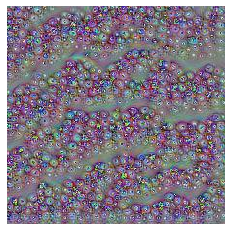

In [19]:
file_path = next(iter(synth_files))
image = parse_image(file_path)

def show(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

show(image)

In [20]:
synth_images_ds = synth_files.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().map(preproccess_synth, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(buffer_size=4400).repeat().batch(global_batch_size)

In [21]:
synth_images_ds

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

generator for training replacement blocks

In [22]:
#%%monitor_cell "layers_vgg"
for target in targets:
    
    print(f"training layer {target['name']}")
    tf.keras.backend.clear_session()
    model = tf.keras.models.load_model('../base_model_cifar10_vgg16.h5')
    in_layer = target['layer']
    get_output = tf.keras.Model(inputs=model.input, outputs=[model.layers[in_layer - 1].output, 
                                                             model.layers[in_layer].output])


    replacement_layers = build_replacement(get_output, layers=2)
    replacement_len = len(replacement_layers.layers)
    layer_train_gen = LayerBatch(get_output, synth_images_ds)
    layer_test_gen = LayerTest(get_output, test_dataset)




    MSE = tf.losses.MeanSquaredError()

    optimizer=tf.keras.optimizers.SGD(.1, momentum=.9, nesterov=True)
    replacement_layers.compile(loss=MSE, optimizer=optimizer)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5, min_lr=.0001, factor=.3, verbose=1)
    early_stop = tf.keras.callbacks.EarlyStopping(patience=15, min_delta=.0001, restore_best_weights=True, verbose=1)
    history = replacement_layers.fit(x=layer_train_gen,
                                   epochs=25,
                                   steps_per_epoch=TRAIN_SIZE // global_batch_size,
                                   validation_data=layer_test_gen,
                                   shuffle=False,
                                   callbacks=[reduce_lr, early_stop],
                                   validation_steps=VALIDATION_SIZE // global_batch_size,
                                   validation_freq=1,
                                   verbose=1)
    target['synth_weights'] = [replacement_layers.layers[1].get_weights(), replacement_layers.layers[3].get_weights()]

training layer block1_conv1
(None, None, None, 3)
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 3125 steps, validate for 625 steps
Epoch 1/25
3125/3125 [==============================] - 902s 289ms/step - loss: 38.4043 - val_loss: 3375.3924
Epoch 2/25
3125/3125 [==============================] - 902s 289ms/step - loss: 12.1508 - val_loss: 3058.9773
Epoch 3/25
3125/3125 [==============================] - 903s 289ms/step - loss: 12.1459 - val_loss: 3486.8350
Epoch 4/25
3125/3125 [==============================] - 902s 289ms/step - loss: 12.1439 - val_loss: 4076.6633
Epoch 5/25
3125/3125 [==============================] - 903s 289ms/step - loss: 12.1427 - val_loss: 4604.8372
Epoch 6/25
3125/3125 [==============================] - 903s 289ms/step - loss: 12.1418 - val_loss: 5122.5584
Epoch 7/25
3124/3125 [============================>.] - ETA: 0s - loss: 12.1411
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.
3125/3125 [==============================] - 905s 290ms/step - loss: 12.1411 - val_loss: 5643.2850
Epoch 8/25
3125/3125 [===============

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 3125 steps, validate for 625 steps
Epoch 1/25
3125/3125 [==============================] - 1413s 452ms/step - loss: 219.5794 - val_loss: 156583.6173
Epoch 2/25
3125/3125 [==============================] - 1415s 453ms/step - loss: 4.4731 - val_loss: 140264.1563
Epoch 3/25
3125/3125 [==============================] - 1416s 453ms/step - loss: 4.2814 - val_loss: 139992.5737
Epoch 4/25
3125/3125 [==============================] - 1417s 453ms/step - loss: 4.2368 - val_loss: 140413.7391
Epoch 5/25
3125/3125 [==============================] - 1417s 453ms/step - loss: 4.2275 - val_loss: 135369.9272
Epoch 6/25
3125/3125 [==============================] - 1418s 454ms/step - loss: 4.2205 - val_loss: 130738.0258
Epoch 7/25
3125/3125 [==============================] - 1417s 453ms/step - loss: 4.2163 - val_loss: 126955.2038
Epoch 8/25
3125/3125 [==============================] - 1419s 454ms/step - loss: 4.2131 - val_loss: 123686.5210
Epoch 9/25
3125/3125 [==============================] - 1

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 3125 steps, validate for 625 steps
Epoch 1/25
3125/3125 [==============================] - 572s 183ms/step - loss: 317.6519 - val_loss: 20268.2939
Epoch 2/25
3125/3125 [==============================] - 574s 184ms/step - loss: 1.9938 - val_loss: 23111.5810
Epoch 3/25
3125/3125 [==============================] - 571s 183ms/step - loss: 0.5768 - val_loss: 20246.3181
Epoch 4/25
3125/3125 [==============================] - 572s 183ms/step - loss: 0.3995 - val_loss: 18403.5017
Epoch 5/25
3125/3125 [==============================] - 572s 183ms/step - loss: 0.3197 - val_loss: 16404.0920
Epoch 6/25
3125/3125 [==============================] - 571s 183ms/step - loss: 0.2787 - val_loss: 15443.6355
Epoch 7/25
3125/3125 [==============================] - 573s 183ms/step - loss: 0.2537 - val_loss: 14802.8408
Epoch 8/25
3125/3125 [==============================] - 569s 182ms/step - loss: 0.2333 - val_loss: 14408.7399
Epoch 9/25
3125/3125 [==============================] - 568s 182ms/step -

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 3125 steps, validate for 625 steps
Epoch 1/25
3125/3125 [==============================] - 693s 222ms/step - loss: 260.5258 - val_loss: 31508.7222
Epoch 2/25
3125/3125 [==============================] - 698s 223ms/step - loss: 1.2249 - val_loss: 29849.1653
Epoch 3/25
3125/3125 [==============================] - 695s 222ms/step - loss: 0.9933 - val_loss: 28839.0499
Epoch 4/25
3125/3125 [==============================] - 694s 222ms/step - loss: 0.8688 - val_loss: 27854.7392
Epoch 5/25
3125/3125 [==============================] - 697s 223ms/step - loss: 0.7682 - val_loss: 27100.6674
Epoch 6/25
3125/3125 [==============================] - 698s 223ms/step - loss: 0.7070 - val_loss: 26531.0533
Epoch 7/25
3125/3125 [==============================] - 697s 223ms/step - loss: 0.6519 - val_loss: 26063.9630
Epoch 8/25
3125/3125 [==============================] - 699s 224ms/step - loss: 0.6018 - val_loss: 25659.0802
Epoch 9/25
3125/3125 [==============================] - 697s 223ms/step -

KeyboardInterrupt: 

I found this code on stackoverflow but It has some problems even though I think it is mostly on the right track

In [ ]:

def make_list(X):
    if isinstance(X, list):
        return X
    return [X]

def list_no_list(X):
    if len(X) == 1:
        return X[0]
    return X

def replace_layer(model, replace_layer_subname, replacement_fn,
**kwargs):
    """
    args:
        model :: keras.models.Model instance
        replace_layer_subname :: str -- if str in layer name, replace it
        replacement_fn :: fn to call to replace all instances
            > fn output must produce shape as the replaced layers input
    returns:
        new model with replaced layers
    quick examples:
        want to just remove all layers with 'batch_norm' in the name:
            > new_model = replace_layer(model, 'batch_norm', lambda **kwargs : (lambda u:u))
        want to replace all Conv1D(N, m, padding='same') with an LSTM (lets say all have 'conv1d' in name)
            > new_model = replace_layer(model, 'conv1d', lambda layer, **kwargs: LSTM(units=layer.filters, return_sequences=True)
    """
    model_inputs = []
    model_outputs = []
    tsr_dict = {}

    model_output_names = [out.name for out in make_list(model.output)]

    for i, layer in enumerate(model.layers):
        ### Loop if layer is used multiple times
        for j in range(len(layer._inbound_nodes)):

            ### check layer inp/outp
            inpt_names = [inp.name for inp in make_list(layer.get_input_at(j))]
            outp_names = [out.name for out in make_list(layer.get_output_at(j))]

            ### setup model inputs
            if 'input' in layer.name:
                for inpt_tsr in make_list(layer.get_output_at(j)):
                    model_inputs.append(inpt_tsr)
                    tsr_dict[inpt_tsr.name] = inpt_tsr
                continue

            ### setup layer inputs
            # I added the exception model_3_3/Identity:0 I think the problem is that is the input layer
            inpt = list_no_list([tsr_dict[name]  for name in inpt_names])

            ### remake layer 
            if layer.name in replace_layer_subname:
              if "relu" in layer.name or 'bn' in layer.name:
                print('deleting ' + layer.name)
                x = inpt
              else:
                print('replacing '+layer.name)
                x = replacement_fn(inpt)
            else:
                x = layer(inpt)

            ### reinstantialize outputs into dict
            for name, out_tsr in zip(outp_names, make_list(x)):

                ### check if is an output
                if name in model_output_names:
                    model_outputs.append(out_tsr)
                tsr_dict[name] = out_tsr

    return tf.keras.models.Model(model_inputs, model_outputs)

In [ ]:
for target in targets:
    
    print(f'Replacing Layer {target["name"]}')
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.load_model('../base_model_cifar10_vgg16.h5')
    
    layer_name = target['name']
    layer_pos = target['layer']
    filters = model.layers[layer_pos].output.shape[-1]
    
    
    new_model = replace_layer(model, layer_name, lambda x: replac(x, filters))
    new_model.layers[layer_pos].set_weights(target['synth_weights'][0])
    new_model.layers[layer_pos + 2].set_weights(target['synth_weights'][1])
    new_model.compile(optimizer=tf.keras.optimizers.SGD(.1), loss="categorical_crossentropy", metrics=['accuracy'])
    target['score'] = new_model.evaluate(test_dataset, steps=VALIDATION_SIZE // global_batch_size)

I think the problem with this is I cannot just insert this model, I need ot add each of the replacement blocks layers one by one

In [ ]:
new_model = replace_layer(model, layers_to_replace, lambda x: replac(x, replacement_layers))

In [ ]:
new_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
new_model.evaluate(test_dataset, steps=VALIDATION_SIZE // global_batch_size)

In [ ]:
new_model.evaluate(test_dataset, steps=VALIDATION_SIZE // global_batch_size)

In [ ]:
layers_to_replace = ["block5_conv3"]